# Data Preprocessing

In [27]:
import pandas as pd
df = pd.read_csv("./SpotifyFeatures.csv")
print (df.shape)
print (df.columns)
df.isnull().sum(axis=0)
# no null values

# Search tracks by an artist name or a track name
def search(df,i):
    if df[df['artist_name'].str.contains(i)].shape[0]>0:
         return df[df['artist_name'].str.contains(i)]
    return df[df['track_name'].str.contains(i)]

cols = ['artist_name', 'track_name','track_id','acousticness', 'danceability', 'duration_ms', 'energy','instrumentalness', 'key', 'liveness', 'loudness', 'mode','speechiness', 'tempo', 'time_signature', 'valence']

(232725, 18)
Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')


genre 26 ['Movie' 'R&B' 'A Capella' 'Alternative' 'Country' 'Dance' 'Electronic'
 'Anime' 'Folk' 'Blues' 'Opera' 'Hip-Hop' "Children's Music" 'Rap' 'Indie'
 'Classical' 'Pop' 'Reggae' 'Reggaeton' 'Jazz' 'Rock' 'Ska' 'Comedy'
 'Soul' 'Soundtrack' 'World']
artist_name 14564 !!! 정진우
track_name 148627 " La Traviata " : Amami Alfredo (Act II) - Digitally Remastered 희재
track_id 176774 00021Wy6AyMbLP2tqij86e 7zzbfi8fvHe6hm342GcNYl
popularity 101 0 100
acousticness 4734 0.0 0.996
danceability 1295 0.0569 0.989
duration_ms 70749 15387 5552917
energy 2517 2.03e-05 0.999
instrumentalness 5400 0.0 0.999
key 12 ['C#' 'F#' 'C' 'F' 'G' 'E' 'D#' 'G#' 'D' 'A#' 'A' 'B']
liveness 1732 0.00967 1.0
loudness 27923 -52.457 3.744
mode 2 ['Major' 'Minor']
speechiness 1641 0.0222 0.967
tempo 78512 30.379 242.903
time_signature 5 ['4-Apr' '4-May' '4-Mar' '4-Jan' '0/4']
valence 1692 0.0 1.0


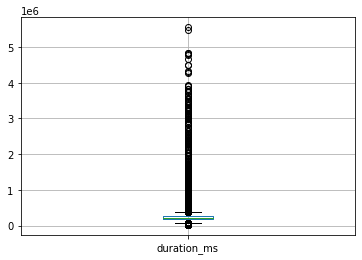

In [28]:
# Check number of unique values and range of each column
for i in df.columns:
    if (df[i].nunique()>30):
        print (i,df[i].nunique(),min(df[i].unique()),max(df[i].unique()))
    else:
        print (i,df[i].nunique(),df[i].unique())

# duration has unusually huge range!
boxplot = df.boxplot(column=['duration_ms'])

# Convert string values into lowercase and remove leading and trailing whitespaces
df['artist_name'] = df['artist_name'].str.lower()
df['track_name'] = df['track_name'].str.lower()
df['genre'] = df['genre'].str.lower()
df['artist_name'] = df['artist_name'].str.strip()
df['track_name'] = df['track_name'].str.strip()
df['genre'] = df['genre'].str.strip()

# Fix apostrophe vs single quote issue in the genre column
df['genre'] = df['genre'].str.replace("’","'")

# Very few rows have duration more than 2e6
# Upon careful inspection it seems that the rows above 2e6 (64 mins) are either podcasts or mixtapes, 
# hence we remove them from the dataset
df_filtered = df[df['duration_ms']<2e6]
df_filtered.reset_index(inplace=True,drop=True)

# There are multiple rows with the same song but different popularity, 
# so we grouped them and kept the one with the maximum popularity
idx = df_filtered.groupby('track_id')['popularity'].transform(max) == df_filtered['popularity']
df_filtered = df_filtered[idx]
df_filtered.reset_index(inplace=True,drop=True)
cols.remove('track_name')
cols.append('popularity')
idx = df_filtered.groupby(cols)['track_name'].transform(max) == df_filtered['track_name']
df_filtered = df_filtered[idx]
df_filtered.reset_index(inplace=True,drop=True)

# Another strange thing is that among 232725 rows, there are just 148615 unique track names.
# This is because songs are present across multiple genres in separate rows.
# we are grouping them and one hot encoding the genre
cols = df_filtered.columns.tolist()
cols.remove('genre')
df_filtered['num_gen'] = df_filtered.groupby(cols,as_index=False)['genre'].transform(len)

df_filtered.reset_index(inplace=True,drop=True)
dummy_genre = pd.get_dummies(df_filtered['genre'], prefix='genre')
df_filtered = pd.merge(left=df_filtered,
        right=dummy_genre,
        left_index=True,
        right_index=True,
    )

df_filtered = df_filtered.drop(columns='genre')
cols = []
cols_genre = []
for i in df_filtered.columns:
    if 'genre' not in i:
        cols.append(i)
    else:
        cols_genre.append(i)

df_filtered = df_filtered.groupby(cols, as_index=False)[cols_genre].apply(lambda x : x.astype(int).sum())
df_filtered.reset_index(inplace=True,drop=True)

# Convert categorical variables into dummy variables
dummy_genre = pd.get_dummies(df_filtered['key'], prefix='key')
df_filtered = pd.merge(left=df_filtered,
        right=dummy_genre,
        left_index=True,
        right_index=True,
    )
df_filtered = df_filtered.drop(columns='key')

dummy_genre = pd.get_dummies(df_filtered['mode'], prefix='mode')
df_filtered = pd.merge(left=df_filtered,
        right=dummy_genre,
        left_index=True,
        right_index=True,
    )
df_filtered = df_filtered.drop(columns='mode')


dummy_genre = pd.get_dummies(df_filtered['time_signature'], prefix='time_signature')
df_filtered = pd.merge(left=df_filtered,
        right=dummy_genre,
        left_index=True,
        right_index=True,
    )
df_filtered = df_filtered.drop(columns='time_signature')

In [29]:
# Store/save the cleaned csv file that wil be used for further analysis
df_filtered.to_csv('Spotify_dataset_filtered.csv',index=False)

In [30]:
print (df_filtered.shape)
print (df_filtered.track_id.nunique())

(176673, 60)
176671


# Reading filtered dataset

In [32]:
import pandas as pd
df = pd.read_csv("./SpotifyFeatures.csv")
def search(df,i):
    if df[df['artist_name'].str.contains(i)].shape[0]>0:
         return df[df['artist_name'].str.contains(i)]
    return df[df['track_name'].str.contains(i)]

df_feat = pd.read_csv("Spotify_dataset_filtered.csv")
df_norm = df_feat.copy()

In [33]:
# Separate out numeric columns
music_attribute_columns = df_feat.columns.tolist()
music_attribute_columns.remove("artist_name")
music_attribute_columns.remove("track_name")
music_attribute_columns.remove("track_id")
music_attribute_columns.remove("popularity")
music_attribute_columns_numeric = ['acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence']

music_attributes_without_genre = ['acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'key_A',
 'key_A#',
 'key_B',
 'key_C',
 'key_C#',
 'key_D',
 'key_D#',
 'key_E',
 'key_F',
 'key_F#',
 'key_G',
 'key_G#',
 'mode_Major',
 'mode_Minor',
 'time_signature_0/4',
 'time_signature_4-Jan',
 'time_signature_4-Mar',
 'time_signature_4-Apr',
 'time_signature_4-May']

print(music_attributes_without_genre)
print(df_norm.columns)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_norm[music_attribute_columns_numeric] = scaler.fit_transform(df_feat[music_attribute_columns_numeric].values)

# Apply PCA to reduce dimensionality to 4
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
new_feat = pca.fit_transform(df_norm[music_attributes_without_genre].values)

['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key_A', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'mode_Major', 'mode_Minor', 'time_signature_0/4', 'time_signature_4-Jan', 'time_signature_4-Mar', 'time_signature_4-Apr', 'time_signature_4-May']
Index(['artist_name', 'track_name', 'track_id', 'popularity', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness',
       'loudness', 'speechiness', 'tempo', 'valence', 'num_gen',
       'genre_a capella', 'genre_alternative', 'genre_anime', 'genre_blues',
       'genre_children's music', 'genre_classical', 'genre_comedy',
       'genre_country', 'genre_dance', 'genre_electronic', 'genre_folk',
       'genre_hip-hop', 'genre_indie', 'genre_jazz', 'genre_movie',
       'genre_opera', 'genre_pop', 'genre_r&b', 'genre_rap', 'genre_reggae',
       'genre_reggaeton', 'genre_

# Similar song selection

In [34]:
# Recommend top five similar songs
# We used PCA to map the data to four dimensions since Nearest Neighbors is expensive in higher dimensions
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(new_feat)

def get_similar_songs(song_name,artist_name):
    df_song = df_feat[df_feat['artist_name'].str.contains(artist_name) & df_feat['track_name'].str.contains(song_name)]
    ind = df_song.index.tolist()
    print ("Returning songs similar to",df_feat.iloc[neigh.kneighbors(new_feat[ind])[1][0]].track_name.values[0],'by',df_feat.iloc[neigh.kneighbors(new_feat[ind])[1][0]].artist_name.values[0])
    return df_feat.iloc[neigh.kneighbors(new_feat[ind])[1][0]][['artist_name','track_name']].values[1:]

get_similar_songs("side to side",'ariana grande')

Returning songs similar to side to side by ariana grande


array([['j. cole', 'born sinner'],
       ['moneybagg yo', 'curry jersey (feat. yg)'],
       ['mark b.', 'aceite en la cintura (mambo version)'],
       ['caramelos de cianuro', "chewin' gum"],
       ['vybz kartel', 'kremlin']], dtype=object)

# Variable selection 

In [5]:
# divide data into train, validation and test sets

from sklearn.model_selection import train_test_split
import numpy as np
df_train, df_val_test = train_test_split(df_feat, test_size=0.3, random_state=5)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=5)

df_train_norm = df_norm.iloc[df_train.index]
df_val_norm = df_norm.iloc[df_val.index]
df_test_norm = df_norm.iloc[df_test.index]

df_train.reset_index(inplace=True,drop=True)
df_val.reset_index(inplace=True,drop=True)
df_test.reset_index(inplace=True,drop=True)
df_train_norm.reset_index(inplace=True,drop=True)
df_val_norm.reset_index(inplace=True,drop=True)
df_test_norm.reset_index(inplace=True,drop=True)

In [35]:
# Identifying which features are highly positively correlated with popularity (means they make the song more popular)
# and which features are highly negatively correlated with popularity (means they make the song less popular, eg. acousticness)
df_train.corr()['popularity']

popularity                1.000000
acousticness             -0.359296
danceability              0.220939
duration_ms               0.035937
energy                    0.234626
instrumentalness         -0.152109
liveness                 -0.161573
loudness                  0.323722
speechiness              -0.162406
tempo                     0.083249
valence                   0.049519
num_gen                   0.457614
genre_a capella          -0.040600
genre_alternative         0.068096
genre_anime              -0.162605
genre_blues              -0.049031
genre_children's music   -0.057590
genre_classical          -0.092311
genre_comedy             -0.208166
genre_country             0.109490
genre_dance               0.231571
genre_electronic          0.014316
genre_folk                0.180544
genre_hip-hop             0.292824
genre_indie               0.247018
genre_jazz                0.057196
genre_movie              -0.296652
genre_opera              -0.294095
genre_pop           

In [36]:
# Implement Lasso 
# ['genre_soundtrack', 'key_E', 'mode_Minor', 'time_signature_0/4','time_signature_3/4', 'time_signature_5/4'] are removed by lasso
# mode_minor is highly correlated with mode_major since if one of them is 0 then other is 1. Hence Lasso removes it.
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
coeff = []
alpha = []
mse = []
for i in np.arange(0.0005,0.005,0.0002):
    clf = Lasso(alpha=i,max_iter=3000).fit(df_train_norm[music_attribute_columns].values, df_train_norm.popularity.values)
    alpha.append(i)
    coeff.append(clf.coef_)
    pred = clf.predict(df_val_norm[music_attribute_columns].values)
    mse.append(mean_squared_error(df_val_norm.popularity.values, pred))

coeff = np.array(coeff)
ind = mse.index(min(mse))
mse=np.array(mse)
music_attribute_columns=np.array(music_attribute_columns)
music_attribute_columns[coeff[ind]==0]

# Hence for linear models we will remove these features

array(['genre_soundtrack', 'key_A', 'key_A#', 'key_E',
       'time_signature_0/4', 'time_signature_4-Mar',
       'time_signature_4-May'], dtype='<U22')

In [8]:
# Finding out relative importance of different features in predicting popularity using XGBoost
import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(df_train[music_attribute_columns],df_train.popularity.values)
score = model.get_booster().get_score(importance_type="gain")
{k: v for k, v in sorted(score.items(), key=lambda item: item[1])}

# seems like time signature and key dont really play a very important role in the song's popularity
# seems like genre plays an important role in predicting the popularity
# importance type gain shows how much does a particular feature help in making the final prediction

{'time_signature_0/4': 120.293823,
 'key_F': 292.76415545294117,
 'time_signature_4-May': 306.884745,
 'key_D': 325.78147379333336,
 'time_signature_4-Jan': 376.0115183254546,
 'time_signature_4-Mar': 426.99650476153846,
 'key_C#': 431.1340888168183,
 'key_G#': 451.30307275,
 'key_A': 471.37049022857144,
 'key_A#': 487.8794773571429,
 'key_B': 493.3664024121054,
 'key_E': 494.1606747222223,
 'key_C': 509.3272748999999,
 'key_F#': 528.1814977153846,
 'key_G': 558.4058134999999,
 'tempo': 568.4446595604668,
 'key_D#': 756.5079497777779,
 'time_signature_4-Apr': 864.3150988941176,
 'speechiness': 883.8098387509634,
 'mode_Major': 942.1441852793106,
 'liveness': 962.0881089073414,
 'energy': 1021.3856202774055,
 'danceability': 1157.3145309618003,
 'instrumentalness': 1313.4397223211229,
 'genre_electronic': 1325.9853810588234,
 'valence': 1503.2314538717858,
 'genre_reggaeton': 1840.5473261090906,
 'duration_ms': 2685.1562436012596,
 'genre_world': 2770.157194627586,
 'loudness': 4776.149

# Model Building

In [38]:
# Fitting a linear regression model
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
# define the model
model = LinearRegression()
# fit the model
music_attribute_columns = np.array(music_attribute_columns)
feat_to_remove = ['genre_soundtrack', 'key_E', 'mode_Minor', 'time_signature_0/4','time_signature_4-Mar', 'time_signature_4-May']
features_reduced = music_attribute_columns.tolist()
for i in feat_to_remove:
    features_reduced.remove(i)
model.fit(df_train[features_reduced].values, df_train['popularity'].values)
pred = model.predict(df_val[features_reduced])
mean_squared_error(df_val.popularity.values, pred)

119.79175367899025

In [10]:
# Fitting a KNN regression model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
# again applying PCA because KNN is extremely expensive in higher dimensions
pca = PCA(n_components=4)
new_feat = pca.fit_transform(df_train_norm[features_reduced].values)
new_val_feat = pca.transform(df_val_norm[features_reduced].values)
params = []
mse = []
for n in range(1,100):
    for weight in ['uniform','distance']:
        neigh = KNeighborsRegressor(n_neighbors=n,weights=weight)
        neigh.fit(new_feat, df_train_norm.popularity.values)
        pred = neigh.predict(new_val_feat)
        params.append([n,weight])
        mse.append(mean_squared_error(df_val_norm.popularity.values, pred))

print ("Minimum MSE is: "+str(min(mse)))
print ("Best set of params is: "+str(params[mse.index(min(mse))]))

Minimum MSE is: 278.30179764210493
Best set of params is: [97, 'uniform']


In [11]:
# Fitting an XGBoost regression model
import xgboost as xgb
eval_set = [(df_val[music_attribute_columns], df_val.popularity.values)]
model = xgb.XGBRegressor(n_jobs=-1,n_estimators=250,random_state=5)
model.fit(df_train[music_attribute_columns], df_train.popularity.values, eval_metric="rmse", eval_set=eval_set, verbose=True, early_stopping_rounds=10)

pred = model.predict(df_val[music_attribute_columns])
mean_squared_error(df_val.popularity.values, pred)


[0]	validation_0-rmse:29.26419
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:22.07030
[2]	validation_0-rmse:17.38447
[3]	validation_0-rmse:14.43693
[4]	validation_0-rmse:12.70532
[5]	validation_0-rmse:11.59780
[6]	validation_0-rmse:10.97354
[7]	validation_0-rmse:10.58339
[8]	validation_0-rmse:10.31940
[9]	validation_0-rmse:10.01301
[10]	validation_0-rmse:9.90305
[11]	validation_0-rmse:9.81288
[12]	validation_0-rmse:9.75458
[13]	validation_0-rmse:9.66035
[14]	validation_0-rmse:9.58688
[15]	validation_0-rmse:9.54428
[16]	validation_0-rmse:9.51387
[17]	validation_0-rmse:9.49375
[18]	validation_0-rmse:9.46770
[19]	validation_0-rmse:9.42246
[20]	validation_0-rmse:9.40942
[21]	validation_0-rmse:9.39362
[22]	validation_0-rmse:9.37036
[23]	validation_0-rmse:9.34540
[24]	validation_0-rmse:9.33204
[25]	validation_0-rmse:9.31790
[26]	validation_0-rmse:9.30367
[27]	validation_0-rmse:9.29963
[28]	validation_0-rmse:9.29085
[29]	validation_0-rmse:9.27882
[30]	

84.17570087700045

## Hyperparameter tuning for XGBoost regression

In [12]:
eval_set = [(df_val[music_attribute_columns], df_val.popularity.values)]
params = []
mse = []
for max_d in [5,6,7]:
    for min_child_weight in [8.5,9,9.5,10,10.5,11]:
        print (max_d)
        model = xgb.XGBRegressor(n_jobs=-1,n_estimators=250,random_state=5,min_child_weight=min_child_weight,max_depth=max_d)
        model.fit(df_train[music_attribute_columns], df_train.popularity.values, eval_metric="rmse", eval_set=eval_set, early_stopping_rounds=10)
        pred = model.predict(df_val[music_attribute_columns])
        params.append({"max_depth":max_d,"min_weight":min_child_weight})
        mse.append(mean_squared_error(df_val.popularity.values, pred))

print ("Best MSE value on validation set: "+str(min(mse)))
print ("Best set of parameters: "+str(params[mse.index(min(mse))]))


5
[0]	validation_0-rmse:29.37553
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:22.26631
[2]	validation_0-rmse:17.63741
[3]	validation_0-rmse:14.74459
[4]	validation_0-rmse:12.95682
[5]	validation_0-rmse:11.88867
[6]	validation_0-rmse:11.27161
[7]	validation_0-rmse:10.85981
[8]	validation_0-rmse:10.59329
[9]	validation_0-rmse:10.34811
[10]	validation_0-rmse:10.20661
[11]	validation_0-rmse:10.11913
[12]	validation_0-rmse:10.01843
[13]	validation_0-rmse:9.94503
[14]	validation_0-rmse:9.89094
[15]	validation_0-rmse:9.85231
[16]	validation_0-rmse:9.80806
[17]	validation_0-rmse:9.74446
[18]	validation_0-rmse:9.70206
[19]	validation_0-rmse:9.66828
[20]	validation_0-rmse:9.64358
[21]	validation_0-rmse:9.60652
[22]	validation_0-rmse:9.58093
[23]	validation_0-rmse:9.57103
[24]	validation_0-rmse:9.55337
[25]	validation_0-rmse:9.51481
[26]	validation_0-rmse:9.49777
[27]	validation_0-rmse:9.48852
[28]	validation_0-rmse:9.47646
[29]	validation_0-rmse:9.45788


[54]	validation_0-rmse:9.27102
[55]	validation_0-rmse:9.26753
[56]	validation_0-rmse:9.26198
[57]	validation_0-rmse:9.25958
[58]	validation_0-rmse:9.25872
[59]	validation_0-rmse:9.24617
[60]	validation_0-rmse:9.24376
[61]	validation_0-rmse:9.24152
[62]	validation_0-rmse:9.24202
[63]	validation_0-rmse:9.24177
[64]	validation_0-rmse:9.24057
[65]	validation_0-rmse:9.23693
[66]	validation_0-rmse:9.23710
[67]	validation_0-rmse:9.23699
[68]	validation_0-rmse:9.23479
[69]	validation_0-rmse:9.23286
[70]	validation_0-rmse:9.23083
[71]	validation_0-rmse:9.23002
[72]	validation_0-rmse:9.22441
[73]	validation_0-rmse:9.22191
[74]	validation_0-rmse:9.22180
[75]	validation_0-rmse:9.22168
[76]	validation_0-rmse:9.21685
[77]	validation_0-rmse:9.21640
[78]	validation_0-rmse:9.21607
[79]	validation_0-rmse:9.21659
[80]	validation_0-rmse:9.21768
[81]	validation_0-rmse:9.21554
[82]	validation_0-rmse:9.21372
[83]	validation_0-rmse:9.21344
[84]	validation_0-rmse:9.21219
[85]	validation_0-rmse:9.21323
[86]	val

[112]	validation_0-rmse:9.20070
[113]	validation_0-rmse:9.20092
[114]	validation_0-rmse:9.20195
[115]	validation_0-rmse:9.20257
[116]	validation_0-rmse:9.20115
[117]	validation_0-rmse:9.20045
[118]	validation_0-rmse:9.20013
[119]	validation_0-rmse:9.20071
[120]	validation_0-rmse:9.20126
[121]	validation_0-rmse:9.20163
[122]	validation_0-rmse:9.20316
[123]	validation_0-rmse:9.20177
[124]	validation_0-rmse:9.20171
[125]	validation_0-rmse:9.20156
[126]	validation_0-rmse:9.20158
[127]	validation_0-rmse:9.19922
[128]	validation_0-rmse:9.19917
[129]	validation_0-rmse:9.19783
[130]	validation_0-rmse:9.19814
[131]	validation_0-rmse:9.19838
[132]	validation_0-rmse:9.19802
[133]	validation_0-rmse:9.19632
[134]	validation_0-rmse:9.19648
[135]	validation_0-rmse:9.19739
[136]	validation_0-rmse:9.19915
[137]	validation_0-rmse:9.19871
[138]	validation_0-rmse:9.19868
[139]	validation_0-rmse:9.19920
[140]	validation_0-rmse:9.19992
[141]	validation_0-rmse:9.19989
[142]	validation_0-rmse:9.20059
[143]	va

[4]	validation_0-rmse:12.70697
[5]	validation_0-rmse:11.59942
[6]	validation_0-rmse:10.97522
[7]	validation_0-rmse:10.58384
[8]	validation_0-rmse:10.22228
[9]	validation_0-rmse:10.07288
[10]	validation_0-rmse:9.95216
[11]	validation_0-rmse:9.86400
[12]	validation_0-rmse:9.79602
[13]	validation_0-rmse:9.70284
[14]	validation_0-rmse:9.65826
[15]	validation_0-rmse:9.62068
[16]	validation_0-rmse:9.57106
[17]	validation_0-rmse:9.53456
[18]	validation_0-rmse:9.50054
[19]	validation_0-rmse:9.48602
[20]	validation_0-rmse:9.43578
[21]	validation_0-rmse:9.41466
[22]	validation_0-rmse:9.39982
[23]	validation_0-rmse:9.39109
[24]	validation_0-rmse:9.37705
[25]	validation_0-rmse:9.36352
[26]	validation_0-rmse:9.34362
[27]	validation_0-rmse:9.33541
[28]	validation_0-rmse:9.32957
[29]	validation_0-rmse:9.32219
[30]	validation_0-rmse:9.31488
[31]	validation_0-rmse:9.30926
[32]	validation_0-rmse:9.30251
[33]	validation_0-rmse:9.29989
[34]	validation_0-rmse:9.29374
[35]	validation_0-rmse:9.29098
[36]	val

[76]	validation_0-rmse:9.20049
[77]	validation_0-rmse:9.19865
[78]	validation_0-rmse:9.19783
[79]	validation_0-rmse:9.19545
[80]	validation_0-rmse:9.19482
[81]	validation_0-rmse:9.19506
[82]	validation_0-rmse:9.19365
[83]	validation_0-rmse:9.19194
[84]	validation_0-rmse:9.19177
[85]	validation_0-rmse:9.19176
[86]	validation_0-rmse:9.19260
[87]	validation_0-rmse:9.19290
[88]	validation_0-rmse:9.19272
[89]	validation_0-rmse:9.19349
[90]	validation_0-rmse:9.19084
[91]	validation_0-rmse:9.18964
[92]	validation_0-rmse:9.18834
[93]	validation_0-rmse:9.18977
[94]	validation_0-rmse:9.18990
[95]	validation_0-rmse:9.19047
[96]	validation_0-rmse:9.19106
[97]	validation_0-rmse:9.19051
[98]	validation_0-rmse:9.19044
[99]	validation_0-rmse:9.18983
[100]	validation_0-rmse:9.18925
[101]	validation_0-rmse:9.18892
[102]	validation_0-rmse:9.18805
[103]	validation_0-rmse:9.18653
[104]	validation_0-rmse:9.18750
[105]	validation_0-rmse:9.18924
[106]	validation_0-rmse:9.18859
[107]	validation_0-rmse:9.18898


[36]	validation_0-rmse:9.21215
[37]	validation_0-rmse:9.21071
[38]	validation_0-rmse:9.21044
[39]	validation_0-rmse:9.21078
[40]	validation_0-rmse:9.21109
[41]	validation_0-rmse:9.20864
[42]	validation_0-rmse:9.20630
[43]	validation_0-rmse:9.20523
[44]	validation_0-rmse:9.20390
[45]	validation_0-rmse:9.20042
[46]	validation_0-rmse:9.20136
[47]	validation_0-rmse:9.19802
[48]	validation_0-rmse:9.19776
[49]	validation_0-rmse:9.19829
[50]	validation_0-rmse:9.19807
[51]	validation_0-rmse:9.19870
[52]	validation_0-rmse:9.19596
[53]	validation_0-rmse:9.19500
[54]	validation_0-rmse:9.19365
[55]	validation_0-rmse:9.19196
[56]	validation_0-rmse:9.19217
[57]	validation_0-rmse:9.18997
[58]	validation_0-rmse:9.19080
[59]	validation_0-rmse:9.19315
[60]	validation_0-rmse:9.19303
[61]	validation_0-rmse:9.19262
[62]	validation_0-rmse:9.19321
[63]	validation_0-rmse:9.19514
[64]	validation_0-rmse:9.19645
[65]	validation_0-rmse:9.19557
[66]	validation_0-rmse:9.19536
[67]	validation_0-rmse:9.19717
Stopping

[1]	validation_0-rmse:21.89038
[2]	validation_0-rmse:17.14604
[3]	validation_0-rmse:14.20504
[4]	validation_0-rmse:12.37824
[5]	validation_0-rmse:11.34640
[6]	validation_0-rmse:10.71388
[7]	validation_0-rmse:10.31358
[8]	validation_0-rmse:10.05716
[9]	validation_0-rmse:9.90985
[10]	validation_0-rmse:9.69402
[11]	validation_0-rmse:9.61713
[12]	validation_0-rmse:9.54761
[13]	validation_0-rmse:9.48623
[14]	validation_0-rmse:9.45970
[15]	validation_0-rmse:9.41293
[16]	validation_0-rmse:9.40226
[17]	validation_0-rmse:9.37708
[18]	validation_0-rmse:9.34960
[19]	validation_0-rmse:9.33436
[20]	validation_0-rmse:9.31544
[21]	validation_0-rmse:9.29940
[22]	validation_0-rmse:9.29493
[23]	validation_0-rmse:9.28380
[24]	validation_0-rmse:9.27488
[25]	validation_0-rmse:9.27021
[26]	validation_0-rmse:9.26261
[27]	validation_0-rmse:9.25705
[28]	validation_0-rmse:9.25338
[29]	validation_0-rmse:9.24932
[30]	validation_0-rmse:9.23911
[31]	validation_0-rmse:9.23618
[32]	validation_0-rmse:9.23189
[33]	vali

In [13]:
eval_set = [(df_val[music_attribute_columns], df_val.popularity.values)]
params = []
mse = []
for subsample in [0.7,0.8,0.8,0.9,1]:
    for colsample in [0.7,0.8,0.8,0.9,1]:
        print (subsample)
        model = xgb.XGBRegressor(n_jobs=-1,n_estimators=250,random_state=5,min_child_weight=8.5,max_depth=6,subsample=subsample,colsample_bytree=colsample)
        model.fit(df_train[music_attribute_columns], df_train.popularity.values, eval_metric="rmse", eval_set=eval_set, early_stopping_rounds=10)
        pred = model.predict(df_val[music_attribute_columns])
        params.append({"subsample":subsample,"colsample_bytree":colsample})
        mse.append(mean_squared_error(df_val.popularity.values, pred))

print ("Best MSE value on validation set: "+str(min(mse)))
print ("Best set of parameters: "+str(params[mse.index(min(mse))]))


0.7
[0]	validation_0-rmse:29.32070
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:22.21004
[2]	validation_0-rmse:17.62093
[3]	validation_0-rmse:14.71169
[4]	validation_0-rmse:12.83671
[5]	validation_0-rmse:11.73683
[6]	validation_0-rmse:11.09558
[7]	validation_0-rmse:10.72736
[8]	validation_0-rmse:10.49656
[9]	validation_0-rmse:10.25225
[10]	validation_0-rmse:10.12491
[11]	validation_0-rmse:9.99691
[12]	validation_0-rmse:9.92286
[13]	validation_0-rmse:9.82107
[14]	validation_0-rmse:9.77738
[15]	validation_0-rmse:9.73947
[16]	validation_0-rmse:9.71109
[17]	validation_0-rmse:9.68049
[18]	validation_0-rmse:9.64255
[19]	validation_0-rmse:9.58923
[20]	validation_0-rmse:9.54987
[21]	validation_0-rmse:9.51946
[22]	validation_0-rmse:9.49369
[23]	validation_0-rmse:9.48077
[24]	validation_0-rmse:9.47117
[25]	validation_0-rmse:9.45693
[26]	validation_0-rmse:9.44010
[27]	validation_0-rmse:9.39760
[28]	validation_0-rmse:9.39094
[29]	validation_0-rmse:9.38217


[13]	validation_0-rmse:9.71115
[14]	validation_0-rmse:9.67753
[15]	validation_0-rmse:9.60542
[16]	validation_0-rmse:9.57791
[17]	validation_0-rmse:9.55179
[18]	validation_0-rmse:9.52168
[19]	validation_0-rmse:9.50440
[20]	validation_0-rmse:9.46928
[21]	validation_0-rmse:9.45406
[22]	validation_0-rmse:9.44278
[23]	validation_0-rmse:9.42306
[24]	validation_0-rmse:9.39363
[25]	validation_0-rmse:9.37865
[26]	validation_0-rmse:9.36296
[27]	validation_0-rmse:9.35295
[28]	validation_0-rmse:9.34622
[29]	validation_0-rmse:9.33547
[30]	validation_0-rmse:9.31817
[31]	validation_0-rmse:9.30617
[32]	validation_0-rmse:9.30247
[33]	validation_0-rmse:9.29749
[34]	validation_0-rmse:9.29673
[35]	validation_0-rmse:9.29290
[36]	validation_0-rmse:9.28483
[37]	validation_0-rmse:9.28383
[38]	validation_0-rmse:9.28251
[39]	validation_0-rmse:9.27371
[40]	validation_0-rmse:9.27106
[41]	validation_0-rmse:9.26137
[42]	validation_0-rmse:9.25805
[43]	validation_0-rmse:9.25611
[44]	validation_0-rmse:9.25652
[45]	val

[32]	validation_0-rmse:9.32214
[33]	validation_0-rmse:9.30237
[34]	validation_0-rmse:9.29131
[35]	validation_0-rmse:9.28887
[36]	validation_0-rmse:9.27899
[37]	validation_0-rmse:9.27539
[38]	validation_0-rmse:9.27313
[39]	validation_0-rmse:9.26876
[40]	validation_0-rmse:9.26435
[41]	validation_0-rmse:9.26316
[42]	validation_0-rmse:9.25928
[43]	validation_0-rmse:9.25853
[44]	validation_0-rmse:9.25257
[45]	validation_0-rmse:9.25231
[46]	validation_0-rmse:9.25188
[47]	validation_0-rmse:9.24737
[48]	validation_0-rmse:9.24380
[49]	validation_0-rmse:9.24274
[50]	validation_0-rmse:9.24303
[51]	validation_0-rmse:9.24218
[52]	validation_0-rmse:9.24174
[53]	validation_0-rmse:9.24276
[54]	validation_0-rmse:9.24282
[55]	validation_0-rmse:9.24324
[56]	validation_0-rmse:9.24030
[57]	validation_0-rmse:9.24185
[58]	validation_0-rmse:9.24102
[59]	validation_0-rmse:9.24160
[60]	validation_0-rmse:9.24311
[61]	validation_0-rmse:9.24180
[62]	validation_0-rmse:9.24318
[63]	validation_0-rmse:9.24021
[64]	val

[39]	validation_0-rmse:9.25311
[40]	validation_0-rmse:9.25077
[41]	validation_0-rmse:9.24479
[42]	validation_0-rmse:9.24227
[43]	validation_0-rmse:9.24249
[44]	validation_0-rmse:9.24148
[45]	validation_0-rmse:9.24169
[46]	validation_0-rmse:9.24045
[47]	validation_0-rmse:9.23978
[48]	validation_0-rmse:9.23826
[49]	validation_0-rmse:9.23849
[50]	validation_0-rmse:9.23422
[51]	validation_0-rmse:9.23067
[52]	validation_0-rmse:9.22829
[53]	validation_0-rmse:9.22573
[54]	validation_0-rmse:9.22789
[55]	validation_0-rmse:9.22777
[56]	validation_0-rmse:9.22750
[57]	validation_0-rmse:9.22616
[58]	validation_0-rmse:9.22563
[59]	validation_0-rmse:9.22732
[60]	validation_0-rmse:9.22715
[61]	validation_0-rmse:9.22771
[62]	validation_0-rmse:9.22891
[63]	validation_0-rmse:9.22861
[64]	validation_0-rmse:9.22527
[65]	validation_0-rmse:9.22585
[66]	validation_0-rmse:9.22690
[67]	validation_0-rmse:9.22645
[68]	validation_0-rmse:9.22606
[69]	validation_0-rmse:9.22802
[70]	validation_0-rmse:9.22698
[71]	val

[52]	validation_0-rmse:9.24174
[53]	validation_0-rmse:9.24276
[54]	validation_0-rmse:9.24282
[55]	validation_0-rmse:9.24324
[56]	validation_0-rmse:9.24030
[57]	validation_0-rmse:9.24185
[58]	validation_0-rmse:9.24102
[59]	validation_0-rmse:9.24160
[60]	validation_0-rmse:9.24311
[61]	validation_0-rmse:9.24180
[62]	validation_0-rmse:9.24318
[63]	validation_0-rmse:9.24021
[64]	validation_0-rmse:9.23984
[65]	validation_0-rmse:9.23759
[66]	validation_0-rmse:9.23697
[67]	validation_0-rmse:9.23727
[68]	validation_0-rmse:9.23656
[69]	validation_0-rmse:9.23748
[70]	validation_0-rmse:9.23874
[71]	validation_0-rmse:9.24017
[72]	validation_0-rmse:9.23923
[73]	validation_0-rmse:9.23974
[74]	validation_0-rmse:9.23981
[75]	validation_0-rmse:9.24012
[76]	validation_0-rmse:9.24101
[77]	validation_0-rmse:9.24019
[78]	validation_0-rmse:9.24084
Stopping. Best iteration:
[68]	validation_0-rmse:9.23656

0.8
[0]	validation_0-rmse:29.31503
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	v

[63]	validation_0-rmse:9.23744
[64]	validation_0-rmse:9.23562
[65]	validation_0-rmse:9.23552
[66]	validation_0-rmse:9.23455
[67]	validation_0-rmse:9.23523
[68]	validation_0-rmse:9.23378
[69]	validation_0-rmse:9.23274
[70]	validation_0-rmse:9.23493
[71]	validation_0-rmse:9.23463
[72]	validation_0-rmse:9.23438
[73]	validation_0-rmse:9.23293
[74]	validation_0-rmse:9.23241
[75]	validation_0-rmse:9.23311
[76]	validation_0-rmse:9.23215
[77]	validation_0-rmse:9.23281
[78]	validation_0-rmse:9.23289
[79]	validation_0-rmse:9.23348
[80]	validation_0-rmse:9.23232
[81]	validation_0-rmse:9.23138
[82]	validation_0-rmse:9.23195
[83]	validation_0-rmse:9.23131
[84]	validation_0-rmse:9.22878
[85]	validation_0-rmse:9.22994
[86]	validation_0-rmse:9.23005
[87]	validation_0-rmse:9.22968
[88]	validation_0-rmse:9.23120
[89]	validation_0-rmse:9.23059
[90]	validation_0-rmse:9.23009
[91]	validation_0-rmse:9.23048
[92]	validation_0-rmse:9.23186
[93]	validation_0-rmse:9.23322
[94]	validation_0-rmse:9.23220
Stopping

[52]	validation_0-rmse:9.21441
[53]	validation_0-rmse:9.21364
[54]	validation_0-rmse:9.21369
[55]	validation_0-rmse:9.21359
[56]	validation_0-rmse:9.21101
[57]	validation_0-rmse:9.21117
[58]	validation_0-rmse:9.21370
[59]	validation_0-rmse:9.21318
[60]	validation_0-rmse:9.21235
[61]	validation_0-rmse:9.21277
[62]	validation_0-rmse:9.21173
[63]	validation_0-rmse:9.21117
[64]	validation_0-rmse:9.21091
[65]	validation_0-rmse:9.21076
[66]	validation_0-rmse:9.21125
[67]	validation_0-rmse:9.21024
[68]	validation_0-rmse:9.20804
[69]	validation_0-rmse:9.20582
[70]	validation_0-rmse:9.20527
[71]	validation_0-rmse:9.20506
[72]	validation_0-rmse:9.20502
[73]	validation_0-rmse:9.20352
[74]	validation_0-rmse:9.20516
[75]	validation_0-rmse:9.20470
[76]	validation_0-rmse:9.20267
[77]	validation_0-rmse:9.20324
[78]	validation_0-rmse:9.20321
[79]	validation_0-rmse:9.20377
[80]	validation_0-rmse:9.20502
[81]	validation_0-rmse:9.20511
[82]	validation_0-rmse:9.20598
[83]	validation_0-rmse:9.20612
[84]	val

[32]	validation_0-rmse:9.30143
[33]	validation_0-rmse:9.29352
[34]	validation_0-rmse:9.28958
[35]	validation_0-rmse:9.28401
[36]	validation_0-rmse:9.27974
[37]	validation_0-rmse:9.27675
[38]	validation_0-rmse:9.27609
[39]	validation_0-rmse:9.26977
[40]	validation_0-rmse:9.26539
[41]	validation_0-rmse:9.26318
[42]	validation_0-rmse:9.26206
[43]	validation_0-rmse:9.25973
[44]	validation_0-rmse:9.25227
[45]	validation_0-rmse:9.24851
[46]	validation_0-rmse:9.24550
[47]	validation_0-rmse:9.24550
[48]	validation_0-rmse:9.24074
[49]	validation_0-rmse:9.23899
[50]	validation_0-rmse:9.23780
[51]	validation_0-rmse:9.23531
[52]	validation_0-rmse:9.23500
[53]	validation_0-rmse:9.23310
[54]	validation_0-rmse:9.23279
[55]	validation_0-rmse:9.23168
[56]	validation_0-rmse:9.23161
[57]	validation_0-rmse:9.23154
[58]	validation_0-rmse:9.23289
[59]	validation_0-rmse:9.23282
[60]	validation_0-rmse:9.23123
[61]	validation_0-rmse:9.23184
[62]	validation_0-rmse:9.23167
[63]	validation_0-rmse:9.22962
[64]	val

[76]	validation_0-rmse:9.20034
[77]	validation_0-rmse:9.19947
[78]	validation_0-rmse:9.19919
[79]	validation_0-rmse:9.19874
[80]	validation_0-rmse:9.19855
[81]	validation_0-rmse:9.19907
[82]	validation_0-rmse:9.20062
[83]	validation_0-rmse:9.20026
[84]	validation_0-rmse:9.19730
[85]	validation_0-rmse:9.19653
[86]	validation_0-rmse:9.19781
[87]	validation_0-rmse:9.19807
[88]	validation_0-rmse:9.19938
[89]	validation_0-rmse:9.19959
[90]	validation_0-rmse:9.20006
[91]	validation_0-rmse:9.20009
[92]	validation_0-rmse:9.20036
[93]	validation_0-rmse:9.19971
[94]	validation_0-rmse:9.20156
[95]	validation_0-rmse:9.20147
Stopping. Best iteration:
[85]	validation_0-rmse:9.19653

1
[0]	validation_0-rmse:29.26424
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:22.07004
[2]	validation_0-rmse:17.38510
[3]	validation_0-rmse:14.43764
[4]	validation_0-rmse:12.70697
[5]	validation_0-rmse:11.59942
[6]	validation_0-rmse:10.97522
[7]	validation_0-rmse:10.58384
[8]	val

In [14]:
eval_set = [(df_val[music_attribute_columns], df_val.popularity.values)]
params = []
mse = []
for lr in [.3, .2, .1, .05, .01, .005]:
    print (lr)
    model = xgb.XGBRegressor(n_jobs=-1,n_estimators=1000,random_state=5,min_child_weight=8.5,max_depth=6,subsample=1,colsample_bytree=1,eta=lr)
    model.fit(df_train[music_attribute_columns], df_train.popularity.values, eval_metric="rmse", eval_set=eval_set, early_stopping_rounds=10)
    pred = model.predict(df_val[music_attribute_columns])
    params.append({"lr":lr})
    mse.append(mean_squared_error(df_val.popularity.values, pred))

print ("Best MSE value on validation set: "+str(min(mse)))
print ("Best set of parameters: "+str(params[mse.index(min(mse))]))


0.3
[0]	validation_0-rmse:29.26424
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:22.07004
[2]	validation_0-rmse:17.38510
[3]	validation_0-rmse:14.43764
[4]	validation_0-rmse:12.70697
[5]	validation_0-rmse:11.59942
[6]	validation_0-rmse:10.97522
[7]	validation_0-rmse:10.58384
[8]	validation_0-rmse:10.22228
[9]	validation_0-rmse:10.07288
[10]	validation_0-rmse:9.95216
[11]	validation_0-rmse:9.86400
[12]	validation_0-rmse:9.79602
[13]	validation_0-rmse:9.70284
[14]	validation_0-rmse:9.65826
[15]	validation_0-rmse:9.62068
[16]	validation_0-rmse:9.57106
[17]	validation_0-rmse:9.53456
[18]	validation_0-rmse:9.50054
[19]	validation_0-rmse:9.48602
[20]	validation_0-rmse:9.43578
[21]	validation_0-rmse:9.41466
[22]	validation_0-rmse:9.39982
[23]	validation_0-rmse:9.39109
[24]	validation_0-rmse:9.37705
[25]	validation_0-rmse:9.36352
[26]	validation_0-rmse:9.34362
[27]	validation_0-rmse:9.33541
[28]	validation_0-rmse:9.32957
[29]	validation_0-rmse:9.32219
[

[52]	validation_0-rmse:9.54071
[53]	validation_0-rmse:9.53219
[54]	validation_0-rmse:9.52347
[55]	validation_0-rmse:9.50325
[56]	validation_0-rmse:9.49591
[57]	validation_0-rmse:9.48254
[58]	validation_0-rmse:9.47616
[59]	validation_0-rmse:9.47033
[60]	validation_0-rmse:9.45674
[61]	validation_0-rmse:9.45078
[62]	validation_0-rmse:9.44184
[63]	validation_0-rmse:9.43064
[64]	validation_0-rmse:9.42588
[65]	validation_0-rmse:9.41806
[66]	validation_0-rmse:9.41480
[67]	validation_0-rmse:9.41056
[68]	validation_0-rmse:9.40711
[69]	validation_0-rmse:9.39933
[70]	validation_0-rmse:9.39337
[71]	validation_0-rmse:9.39041
[72]	validation_0-rmse:9.37547
[73]	validation_0-rmse:9.36908
[74]	validation_0-rmse:9.36472
[75]	validation_0-rmse:9.35732
[76]	validation_0-rmse:9.35368
[77]	validation_0-rmse:9.34811
[78]	validation_0-rmse:9.34254
[79]	validation_0-rmse:9.33803
[80]	validation_0-rmse:9.33396
[81]	validation_0-rmse:9.32640
[82]	validation_0-rmse:9.31768
[83]	validation_0-rmse:9.31338
[84]	val

[310]	validation_0-rmse:9.14314
[311]	validation_0-rmse:9.14299
[312]	validation_0-rmse:9.14348
[313]	validation_0-rmse:9.14330
[314]	validation_0-rmse:9.14279
[315]	validation_0-rmse:9.14250
[316]	validation_0-rmse:9.14243
[317]	validation_0-rmse:9.14238
[318]	validation_0-rmse:9.14149
[319]	validation_0-rmse:9.14148
[320]	validation_0-rmse:9.14140
[321]	validation_0-rmse:9.14105
[322]	validation_0-rmse:9.14123
[323]	validation_0-rmse:9.14058
[324]	validation_0-rmse:9.14097
[325]	validation_0-rmse:9.14062
[326]	validation_0-rmse:9.14031
[327]	validation_0-rmse:9.13980
[328]	validation_0-rmse:9.13966
[329]	validation_0-rmse:9.13972
[330]	validation_0-rmse:9.13966
[331]	validation_0-rmse:9.13964
[332]	validation_0-rmse:9.13989
[333]	validation_0-rmse:9.13919
[334]	validation_0-rmse:9.13921
[335]	validation_0-rmse:9.13865
[336]	validation_0-rmse:9.13844
[337]	validation_0-rmse:9.13830
[338]	validation_0-rmse:9.13821
[339]	validation_0-rmse:9.13824
[340]	validation_0-rmse:9.13865
[341]	va

[215]	validation_0-rmse:9.22374
[216]	validation_0-rmse:9.22238
[217]	validation_0-rmse:9.22071
[218]	validation_0-rmse:9.21966
[219]	validation_0-rmse:9.21876
[220]	validation_0-rmse:9.21858
[221]	validation_0-rmse:9.21717
[222]	validation_0-rmse:9.21621
[223]	validation_0-rmse:9.21522
[224]	validation_0-rmse:9.21448
[225]	validation_0-rmse:9.21308
[226]	validation_0-rmse:9.21236
[227]	validation_0-rmse:9.21200
[228]	validation_0-rmse:9.21131
[229]	validation_0-rmse:9.21040
[230]	validation_0-rmse:9.21004
[231]	validation_0-rmse:9.20973
[232]	validation_0-rmse:9.20895
[233]	validation_0-rmse:9.20849
[234]	validation_0-rmse:9.20746
[235]	validation_0-rmse:9.20617
[236]	validation_0-rmse:9.20611
[237]	validation_0-rmse:9.20548
[238]	validation_0-rmse:9.20468
[239]	validation_0-rmse:9.20383
[240]	validation_0-rmse:9.20253
[241]	validation_0-rmse:9.20114
[242]	validation_0-rmse:9.20061
[243]	validation_0-rmse:9.19958
[244]	validation_0-rmse:9.19955
[245]	validation_0-rmse:9.19898
[246]	va

[472]	validation_0-rmse:9.13969
[473]	validation_0-rmse:9.13974
[474]	validation_0-rmse:9.13973
[475]	validation_0-rmse:9.13937
[476]	validation_0-rmse:9.13929
[477]	validation_0-rmse:9.13904
[478]	validation_0-rmse:9.13909
[479]	validation_0-rmse:9.13897
[480]	validation_0-rmse:9.13831
[481]	validation_0-rmse:9.13809
[482]	validation_0-rmse:9.13781
[483]	validation_0-rmse:9.13771
[484]	validation_0-rmse:9.13731
[485]	validation_0-rmse:9.13717
[486]	validation_0-rmse:9.13715
[487]	validation_0-rmse:9.13690
[488]	validation_0-rmse:9.13688
[489]	validation_0-rmse:9.13690
[490]	validation_0-rmse:9.13640
[491]	validation_0-rmse:9.13662
[492]	validation_0-rmse:9.13655
[493]	validation_0-rmse:9.13634
[494]	validation_0-rmse:9.13597
[495]	validation_0-rmse:9.13590
[496]	validation_0-rmse:9.13592
[497]	validation_0-rmse:9.13593
[498]	validation_0-rmse:9.13577
[499]	validation_0-rmse:9.13515
[500]	validation_0-rmse:9.13460
[501]	validation_0-rmse:9.13459
[502]	validation_0-rmse:9.13466
[503]	va

[203]	validation_0-rmse:11.72533
[204]	validation_0-rmse:11.69912
[205]	validation_0-rmse:11.67383
[206]	validation_0-rmse:11.64633
[207]	validation_0-rmse:11.62143
[208]	validation_0-rmse:11.59701
[209]	validation_0-rmse:11.57266
[210]	validation_0-rmse:11.54893
[211]	validation_0-rmse:11.52327
[212]	validation_0-rmse:11.49972
[213]	validation_0-rmse:11.47726
[214]	validation_0-rmse:11.45465
[215]	validation_0-rmse:11.43286
[216]	validation_0-rmse:11.41096
[217]	validation_0-rmse:11.38737
[218]	validation_0-rmse:11.36623
[219]	validation_0-rmse:11.34537
[220]	validation_0-rmse:11.32388
[221]	validation_0-rmse:11.30385
[222]	validation_0-rmse:11.28388
[223]	validation_0-rmse:11.26431
[224]	validation_0-rmse:11.24431
[225]	validation_0-rmse:11.22292
[226]	validation_0-rmse:11.20335
[227]	validation_0-rmse:11.18492
[228]	validation_0-rmse:11.16671
[229]	validation_0-rmse:11.14814
[230]	validation_0-rmse:11.12958
[231]	validation_0-rmse:11.10912
[232]	validation_0-rmse:11.09200
[233]	vali

[455]	validation_0-rmse:9.65398
[456]	validation_0-rmse:9.65181
[457]	validation_0-rmse:9.65060
[458]	validation_0-rmse:9.64888
[459]	validation_0-rmse:9.64669
[460]	validation_0-rmse:9.64493
[461]	validation_0-rmse:9.64181
[462]	validation_0-rmse:9.63919
[463]	validation_0-rmse:9.63736
[464]	validation_0-rmse:9.63603
[465]	validation_0-rmse:9.63446
[466]	validation_0-rmse:9.63236
[467]	validation_0-rmse:9.63107
[468]	validation_0-rmse:9.63005
[469]	validation_0-rmse:9.62861
[470]	validation_0-rmse:9.62676
[471]	validation_0-rmse:9.62525
[472]	validation_0-rmse:9.62351
[473]	validation_0-rmse:9.62176
[474]	validation_0-rmse:9.62034
[475]	validation_0-rmse:9.61901
[476]	validation_0-rmse:9.61739
[477]	validation_0-rmse:9.61495
[478]	validation_0-rmse:9.61301
[479]	validation_0-rmse:9.61206
[480]	validation_0-rmse:9.61012
[481]	validation_0-rmse:9.60881
[482]	validation_0-rmse:9.60726
[483]	validation_0-rmse:9.60603
[484]	validation_0-rmse:9.60470
[485]	validation_0-rmse:9.60381
[486]	va

[712]	validation_0-rmse:9.37658
[713]	validation_0-rmse:9.37621
[714]	validation_0-rmse:9.37582
[715]	validation_0-rmse:9.37541
[716]	validation_0-rmse:9.37506
[717]	validation_0-rmse:9.37434
[718]	validation_0-rmse:9.37365
[719]	validation_0-rmse:9.37321
[720]	validation_0-rmse:9.37254
[721]	validation_0-rmse:9.37205
[722]	validation_0-rmse:9.37168
[723]	validation_0-rmse:9.37072
[724]	validation_0-rmse:9.37025
[725]	validation_0-rmse:9.36995
[726]	validation_0-rmse:9.36953
[727]	validation_0-rmse:9.36919
[728]	validation_0-rmse:9.36857
[729]	validation_0-rmse:9.36782
[730]	validation_0-rmse:9.36753
[731]	validation_0-rmse:9.36662
[732]	validation_0-rmse:9.36576
[733]	validation_0-rmse:9.36544
[734]	validation_0-rmse:9.36453
[735]	validation_0-rmse:9.36383
[736]	validation_0-rmse:9.36295
[737]	validation_0-rmse:9.36272
[738]	validation_0-rmse:9.36219
[739]	validation_0-rmse:9.36149
[740]	validation_0-rmse:9.36083
[741]	validation_0-rmse:9.36055
[742]	validation_0-rmse:9.36022
[743]	va

[969]	validation_0-rmse:9.26225
[970]	validation_0-rmse:9.26203
[971]	validation_0-rmse:9.26169
[972]	validation_0-rmse:9.26155
[973]	validation_0-rmse:9.26117
[974]	validation_0-rmse:9.26088
[975]	validation_0-rmse:9.26041
[976]	validation_0-rmse:9.26013
[977]	validation_0-rmse:9.25979
[978]	validation_0-rmse:9.25941
[979]	validation_0-rmse:9.25923
[980]	validation_0-rmse:9.25896
[981]	validation_0-rmse:9.25869
[982]	validation_0-rmse:9.25835
[983]	validation_0-rmse:9.25799
[984]	validation_0-rmse:9.25781
[985]	validation_0-rmse:9.25747
[986]	validation_0-rmse:9.25720
[987]	validation_0-rmse:9.25702
[988]	validation_0-rmse:9.25671
[989]	validation_0-rmse:9.25639
[990]	validation_0-rmse:9.25602
[991]	validation_0-rmse:9.25569
[992]	validation_0-rmse:9.25523
[993]	validation_0-rmse:9.25507
[994]	validation_0-rmse:9.25481
[995]	validation_0-rmse:9.25451
[996]	validation_0-rmse:9.25388
[997]	validation_0-rmse:9.25347
[998]	validation_0-rmse:9.25316
[999]	validation_0-rmse:9.25287
0.005
[0

[220]	validation_0-rmse:16.93628
[221]	validation_0-rmse:16.88704
[222]	validation_0-rmse:16.83800
[223]	validation_0-rmse:16.78901
[224]	validation_0-rmse:16.74035
[225]	validation_0-rmse:16.69217
[226]	validation_0-rmse:16.64420
[227]	validation_0-rmse:16.59655
[228]	validation_0-rmse:16.54898
[229]	validation_0-rmse:16.50210
[230]	validation_0-rmse:16.45508
[231]	validation_0-rmse:16.40908
[232]	validation_0-rmse:16.36275
[233]	validation_0-rmse:16.31696
[234]	validation_0-rmse:16.27141
[235]	validation_0-rmse:16.22568
[236]	validation_0-rmse:16.18068
[237]	validation_0-rmse:16.13648
[238]	validation_0-rmse:16.09218
[239]	validation_0-rmse:16.04771
[240]	validation_0-rmse:16.00383
[241]	validation_0-rmse:15.96087
[242]	validation_0-rmse:15.91760
[243]	validation_0-rmse:15.87439
[244]	validation_0-rmse:15.83178
[245]	validation_0-rmse:15.78900
[246]	validation_0-rmse:15.74702
[247]	validation_0-rmse:15.70573
[248]	validation_0-rmse:15.66420
[249]	validation_0-rmse:15.62286
[250]	vali

[469]	validation_0-rmse:11.06342
[470]	validation_0-rmse:11.05521
[471]	validation_0-rmse:11.04706
[472]	validation_0-rmse:11.03740
[473]	validation_0-rmse:11.02931
[474]	validation_0-rmse:11.02093
[475]	validation_0-rmse:11.01254
[476]	validation_0-rmse:11.00465
[477]	validation_0-rmse:10.99535
[478]	validation_0-rmse:10.98724
[479]	validation_0-rmse:10.97947
[480]	validation_0-rmse:10.97137
[481]	validation_0-rmse:10.96338
[482]	validation_0-rmse:10.95440
[483]	validation_0-rmse:10.94698
[484]	validation_0-rmse:10.93962
[485]	validation_0-rmse:10.93218
[486]	validation_0-rmse:10.92334
[487]	validation_0-rmse:10.91624
[488]	validation_0-rmse:10.90896
[489]	validation_0-rmse:10.90184
[490]	validation_0-rmse:10.89331
[491]	validation_0-rmse:10.88619
[492]	validation_0-rmse:10.87908
[493]	validation_0-rmse:10.87175
[494]	validation_0-rmse:10.86343
[495]	validation_0-rmse:10.85651
[496]	validation_0-rmse:10.84959
[497]	validation_0-rmse:10.84299
[498]	validation_0-rmse:10.83614
[499]	vali

[718]	validation_0-rmse:9.94834
[719]	validation_0-rmse:9.94641
[720]	validation_0-rmse:9.94454
[721]	validation_0-rmse:9.94132
[722]	validation_0-rmse:9.93979
[723]	validation_0-rmse:9.93794
[724]	validation_0-rmse:9.93475
[725]	validation_0-rmse:9.93308
[726]	validation_0-rmse:9.93119
[727]	validation_0-rmse:9.92939
[728]	validation_0-rmse:9.92617
[729]	validation_0-rmse:9.92465
[730]	validation_0-rmse:9.92295
[731]	validation_0-rmse:9.91984
[732]	validation_0-rmse:9.91839
[733]	validation_0-rmse:9.91585
[734]	validation_0-rmse:9.91411
[735]	validation_0-rmse:9.91280
[736]	validation_0-rmse:9.90977
[737]	validation_0-rmse:9.90812
[738]	validation_0-rmse:9.90673
[739]	validation_0-rmse:9.90353
[740]	validation_0-rmse:9.90183
[741]	validation_0-rmse:9.90056
[742]	validation_0-rmse:9.89896
[743]	validation_0-rmse:9.89593
[744]	validation_0-rmse:9.89426
[745]	validation_0-rmse:9.89291
[746]	validation_0-rmse:9.89050
[747]	validation_0-rmse:9.88888
[748]	validation_0-rmse:9.88586
[749]	va

[975]	validation_0-rmse:9.59549
[976]	validation_0-rmse:9.59482
[977]	validation_0-rmse:9.59432
[978]	validation_0-rmse:9.59299
[979]	validation_0-rmse:9.59193
[980]	validation_0-rmse:9.59076
[981]	validation_0-rmse:9.59007
[982]	validation_0-rmse:9.58901
[983]	validation_0-rmse:9.58856
[984]	validation_0-rmse:9.58764
[985]	validation_0-rmse:9.58700
[986]	validation_0-rmse:9.58593
[987]	validation_0-rmse:9.58530
[988]	validation_0-rmse:9.58489
[989]	validation_0-rmse:9.58423
[990]	validation_0-rmse:9.58287
[991]	validation_0-rmse:9.58243
[992]	validation_0-rmse:9.58142
[993]	validation_0-rmse:9.58053
[994]	validation_0-rmse:9.58006
[995]	validation_0-rmse:9.57919
[996]	validation_0-rmse:9.57869
[997]	validation_0-rmse:9.57807
[998]	validation_0-rmse:9.57681
[999]	validation_0-rmse:9.57620
Best MSE value on validation set: 83.42988213920052
Best set of parameters: {'lr': 0.05}


In [15]:
# Fitting a neural network regression model
from sklearn.neural_network import MLPRegressor
#NN perform better with scaled data
regr = MLPRegressor(hidden_layer_sizes=(100),random_state=5, max_iter=500, early_stopping=True).fit(df_train_norm[music_attribute_columns], df_train_norm.popularity.values)
pred = regr.predict(df_val_norm[music_attribute_columns])
mean_squared_error(df_val_norm.popularity.values, pred)

273.1000397105488

In [16]:
# XGBoost performed the best on the validation set. Using the XGBoost model to predict on test set 
# and evaluating performance
# However we train this model on both train and validation set
# We get a mse of 78.51 on the test set (lower than what we got on the validation set)
model = xgb.XGBRegressor(n_jobs=-1,n_estimators=600,random_state=5,min_child_weight=8.5,max_depth=6,subsample=1,colsample_bytree=1,eta=0.05)
df_train_with_val = df_train.append(df_val,ignore_index=True)
model.fit(df_train_with_val[music_attribute_columns], df_train_with_val.popularity.values, eval_metric="rmse")

pred = model.predict(df_test[music_attribute_columns])

mean_squared_error(df_test.popularity.values, pred)


78.71454786131054

# Trying to break the popularity into ranges and using classification with xgboost

In [17]:
# Trying an alternative approach - a multi-class classification approach to classify a track's popularity into
# a category, instead of predicting the exact popularity value

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
names = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
df_train['PopularityRange'] = pd.cut(df_train['popularity'], bins, labels=names, include_lowest=True)
df_val['PopularityRange'] = pd.cut(df_val['popularity'], bins, labels=names, include_lowest=True)

eval_set = [(df_val[music_attribute_columns], df_val.PopularityRange.values)]
model = xgb.XGBClassifier(n_jobs=-1,n_estimators=250,random_state=5,objective='multi:softmax')
model.fit(df_train[music_attribute_columns], df_train.PopularityRange.values, eval_set=eval_set, verbose=True, early_stopping_rounds=10)

<ipython-input-17-8b6f17e6c2e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['PopularityRange'] = pd.cut(df_train['popularity'], bins, labels=names, include_lowest=True)
<ipython-input-17-8b6f17e6c2e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['PopularityRange'] = pd.cut(df_val['popularity'], bins, labels=names, include_lowest=True)


[0]	validation_0-merror:0.52375
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.51179
[2]	validation_0-merror:0.51119
[3]	validation_0-merror:0.51081
[4]	validation_0-merror:0.50855
[5]	validation_0-merror:0.50945
[6]	validation_0-merror:0.50787
[7]	validation_0-merror:0.50794
[8]	validation_0-merror:0.50749
[9]	validation_0-merror:0.50651
[10]	validation_0-merror:0.50636
[11]	validation_0-merror:0.50617
[12]	validation_0-merror:0.50677
[13]	validation_0-merror:0.50681
[14]	validation_0-merror:0.50662
[15]	validation_0-merror:0.50470
[16]	validation_0-merror:0.50466
[17]	validation_0-merror:0.50530
[18]	validation_0-merror:0.50534
[19]	validation_0-merror:0.50496
[20]	validation_0-merror:0.50541
[21]	validation_0-merror:0.50470
[22]	validation_0-merror:0.50481
[23]	validation_0-merror:0.50455
[24]	validation_0-merror:0.50470
[25]	validation_0-merror:0.50447
[26]	validation_0-merror:0.50428
[27]	validation_0-merror:0.50330
[28]	validation_0-m

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=5, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

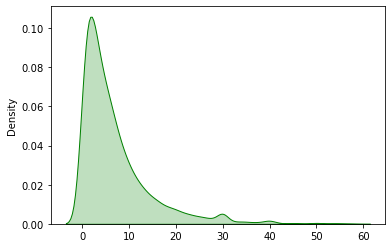

In [18]:
# For all the tracks that are misclassified, let's find out how much their values differ from their
# true values. We'll plot a kernel density estimation (KDE) for this purpose
import seaborn as sns

pred = model.predict(df_val[music_attribute_columns])
misclassified_range = []
for i in range(len(pred)):
    if pred[i]!=df_val.iloc[i]['PopularityRange']:
        if abs(int(pred[i].split('-')[1])-df_val.iloc[i]['popularity'])<abs(int(pred[i].split('-')[0])-df_val.iloc[i]['popularity']):
            misclassified_range.append(abs(int(pred[i].split('-')[1])-df_val.iloc[i]['popularity']))
        else:
            misclassified_range.append(abs(int(pred[i].split('-')[0])-df_val.iloc[i]['popularity']))


sns.kdeplot(misclassified_range, bw_adjust=1, label='Misclassification extent of classifier', shade=True, color = "g")
plt.show()

# The graph shows that we are correctly able to predict the popularity value within a difference of 10 in case of
# misclassifications, thus our model might not be able to predict the exact popularity value 
# but can give a good enough estimate of the category such as not popular, moderately popular, super popular etc.

## As an additional step, let's see if K-means will be be able to cluster songs, based on their popularity

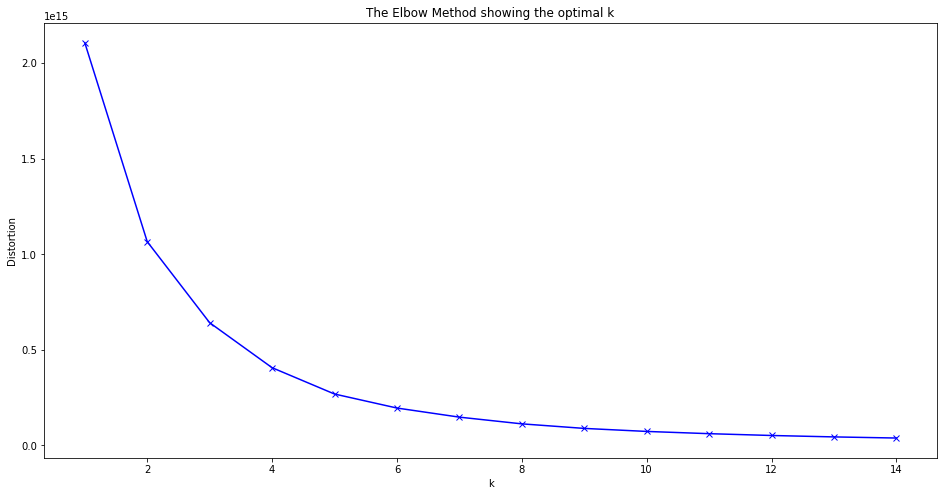

In [20]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# again applying PCA because KNN is extremely expensive in higher dimensions
pca = PCA(n_components=4)
new_feat = pca.fit_transform(df_norm[features_reduced].values)

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(new_feat)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# plot shows optimum k as 4 (elbow test)

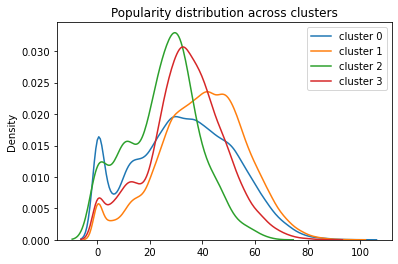

In [21]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(new_feat)
import seaborn as sns
sns.kdeplot(df_norm.iloc[kmeanModel.labels_==0].popularity.values, bw_adjust=1, label='cluster 0')
sns.kdeplot(df_norm.iloc[kmeanModel.labels_==1].popularity.values, bw_adjust=1, label='cluster 1')
sns.kdeplot(df_norm.iloc[kmeanModel.labels_==2].popularity.values, bw_adjust=1, label='cluster 2')
sns.kdeplot(df_norm.iloc[kmeanModel.labels_==3].popularity.values, bw_adjust=1, label='cluster 3')
plt.title("Popularity distribution across clusters")
plt.legend()

In [ ]:
## Evidently, there’s no clear segregation based on popularity among these clusters.